In [1]:
import numpy as np
import pandas as pd
import scipy as sc
from statsmodels.stats.descriptivestats import sign_test
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math
from tqdm import tqdm
from collections import defaultdict

In [2]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/"
sys.path.append(new_path)
classpath = 'd:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/adaboost_java/lib-adaboost.jar'

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
#from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;
from adaboost_java.ada_boost_java_v1 import AdaBoostJavaClassifier_v1;

In [3]:
def generate_data(n_samples=300, n_features=50,n_informative=20, n_redundant=20, gap=0.1):
    x_raw, _ = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative
                                   , n_redundant=n_redundant, n_clusters_per_class=5, shuffle=False) #, random_state=0

    x_data, y_data, v_normal = make_separable_labels(x_raw, gap)
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=1/3) #, random_state=42)
    return X_train, X_test, y_train, y_test

In [4]:
#Linear
def get_predicts_linear_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostLinear_v1()
    result, message, _ = clf.fit(X_train, y_train, allow_nonseparable=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    margin = clf.get_margin()
    return y_pred, margin, separated, clf

#Ada-boost decision-stump
def get_predict_stump_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostStandardClassifier_v1(n_estimators=150)
    clf.fit(X_train, y_train, trace=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

#Java
def get_predicts_java_v1(X_train, X_test, y_train, y_test, n_estimators):
    clf = AdaBoostJavaClassifier_v1(path=classpath)
    clf.fit(X_train, y_train, n_estimators)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

In [5]:
def get_metrics(X_train, X_test, y_train, y_test, n_estimators = 150):
    metrics_linear={}
    metrics_stump={}
    #Linear
    y_pred_linear, margin, separated, clf = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    if separated < 1:
        raise Exception("Linear classifier splits {} part of the data".format(separated))
    metrics_linear['risk'] = 1 - accuracy_score(y_test, y_pred_linear)
    metrics_linear['precision'] = precision_score(y_test, y_pred_linear)
    metrics_linear['recall'] = recall_score(y_test, y_pred_linear)
    metrics_linear['margin'] = margin
    #Ada-boost decision-stump
    y_pred_stump, margin, separated, clf = get_predicts_java_v1(X_train, X_test, y_train, y_test, n_estimators)
    if separated < 1:
        raise Exception("AdaBoost classifier splits {} part of the data".format(separated))
    metrics_stump['risk'] = 1 - accuracy_score(y_test, y_pred_stump)
    metrics_stump['precision'] = precision_score(y_test, y_pred_stump)
    metrics_stump['recall'] = recall_score(y_test, y_pred_stump)
    metrics_stump['margin'] = margin
    return metrics_linear, metrics_stump

### 1. Varying the number of features from 25 to 300, 300 samples

In [76]:
TESTS_COUNT=5

features_numbers=[25,50,75,100,125,150,175,200,225,250,275,300]

marginL, marginJ, riskL, riskJ = [], [], [], []
avg_marginL, avg_marginJ, avg_riskL, avg_riskJ = [], [], [], []

for features_number in tqdm(features_numbers):
    n_features, n_informative, n_redundant= features_number, int(features_number*0.4), int(features_number*0.4) #features, 0
    buff_riskL, buff_riskJ, buff_marginL, buff_marginJ=[], [], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metricsL, metricsJ = get_metrics(X_train, X_test, y_train, y_test)
        buff_riskL.append(metricsL['risk'])
        buff_riskJ.append(metricsJ['risk'])
        buff_marginL.append(metricsL['margin'])
        buff_marginJ.append(metricsJ['margin'])
        
    riskL.append(buff_riskL)
    riskJ.append(buff_riskJ)
    marginL.append(buff_marginL)
    marginJ.append(buff_marginJ)
    avg_riskL.append(sum(buff_riskL)/TESTS_COUNT)
    avg_riskJ.append(sum(buff_riskJ)/TESTS_COUNT)
    avg_marginL.append(sum(buff_marginL)/TESTS_COUNT)
    avg_marginJ.append(sum(buff_marginJ)/TESTS_COUNT)
    
marginL, marginJ, riskL, riskJ = np.array(marginL), np.array(marginJ), np.array(riskL), np.array(riskJ)


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [2:02:06<00:00, 610.52s/it]


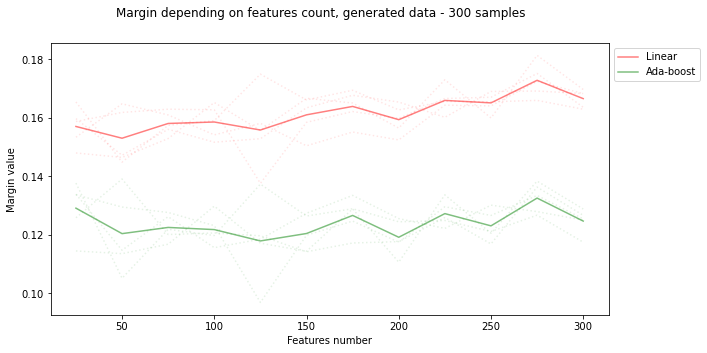

In [77]:
options = [
    ('r', 'Linear'),
    ('g', 'Ada-boost'),
]

plt.figure(figsize=(10, 5))
plt.xlabel('Features number')
plt.ylabel('Margin value')
plt.suptitle("Margin depending on features count, generated data - 300 samples")

for pos in range(TESTS_COUNT):
    plt.plot(features_list, marginL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(features_list, marginJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(features_list, avg_marginL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(features_list, avg_marginJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

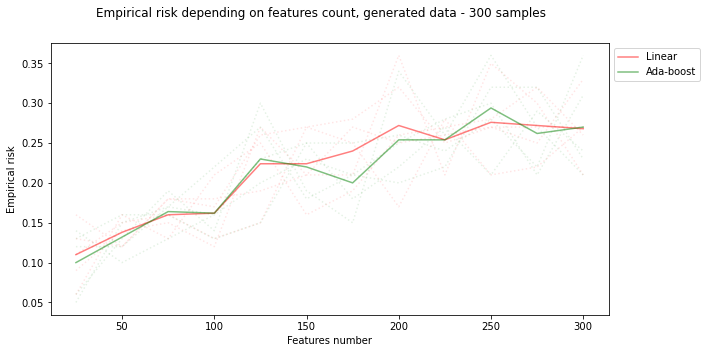

In [78]:
plt.figure(figsize=(10, 5))
plt.xlabel('Features number')
plt.ylabel('Empirical risk')
plt.suptitle("Empirical risk depending on features count, generated data - 300 samples")

for pos in range(TESTS_COUNT):
    plt.plot(features_list, riskL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(features_list, riskJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(features_list, avg_riskL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(features_list, avg_riskJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

#### 1.1. Checking for statistically significant differences between experimental errors of classifier versions

In [80]:
risk_flatL = riskL.flatten('F')
risk_flatJ = riskJ.flatten('F')
print("Sign test:", sign_test(risk_flatL - risk_flatJ))
print("Signed rank test:", sc.stats.wilcoxon(risk_flatL, risk_flatJ))
print("Mann-Whitney test:", sc.stats.mannwhitneyu(risk_flatL, risk_flatJ))

Sign test: (4.0, 0.3317497633694906)
Signed rank test: WilcoxonResult(statistic=573.5, pvalue=0.29048096603448925)
Mann-Whitney test: MannwhitneyuResult(statistic=1884.5, pvalue=0.6586795053726658)


### 2. Varying the number of samples from 100 to 500, 50 features

In [81]:
TESTS_COUNT=5

samples_numbers=[100,150,200,250,300,350,400,450,500]

marginL, marginJ, riskL, riskJ = [], [], [], []
avg_marginL, avg_marginJ, avg_riskL, avg_riskJ = [], [], [], []

for samples_number in tqdm(samples_numbers):
    buff_riskL, buff_riskJ, buff_marginL, buff_marginJ=[], [], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data(n_samples=samples_number)
        metricsL, metricsJ = get_metrics(X_train, X_test, y_train, y_test)
        buff_riskL.append(metricsL['risk'])
        buff_riskJ.append(metricsJ['risk'])
        buff_marginL.append(metricsL['margin'])
        buff_marginJ.append(metricsJ['margin'])
        
    riskL.append(buff_riskL)
    riskJ.append(buff_riskJ)
    marginL.append(buff_marginL)
    marginJ.append(buff_marginJ)
    avg_riskL.append(sum(buff_riskL)/TESTS_COUNT)
    avg_riskJ.append(sum(buff_riskJ)/TESTS_COUNT)
    avg_marginL.append(sum(buff_marginL)/TESTS_COUNT)
    avg_marginJ.append(sum(buff_marginJ)/TESTS_COUNT)
    
marginL, marginJ, riskL, riskJ = np.array(marginL), np.array(marginJ), np.array(riskL), np.array(riskJ)


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [31:43<00:00, 211.51s/it]


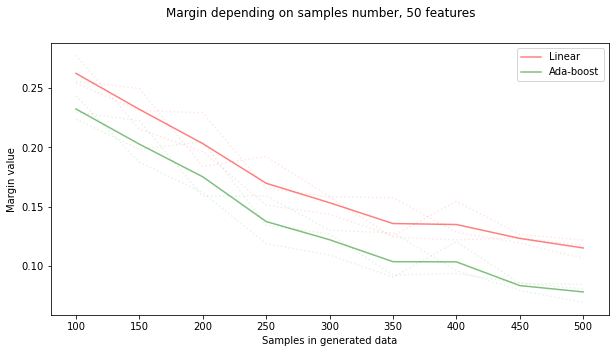

In [60]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Margin value')
plt.suptitle("Margin depending on samples number, 50 features")

for pos in range(TESTS_COUNT):
    plt.plot(samples_numbers, marginL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(samples_numbers, marginJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(samples_numbers, avg_marginL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(samples_numbers, avg_marginJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

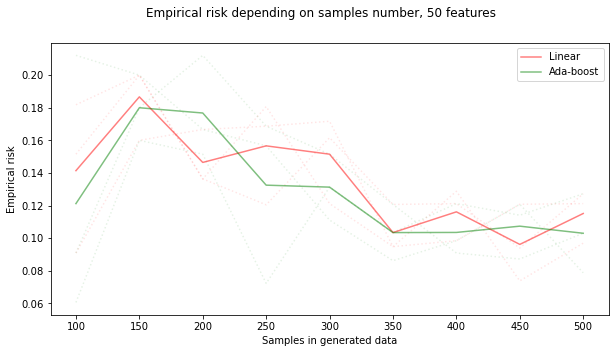

In [62]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Empirical risk')
plt.suptitle("Empirical risk depending on samples number, 50 features")

for pos in range(TESTS_COUNT):
    plt.plot(samples_numbers, riskL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(samples_numbers, riskJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(samples_numbers, avg_riskL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(samples_numbers, avg_riskJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

#### 2.1. Checking for statistically significant differences between experimental errors of classifier versions

In [88]:
risk_flatL = riskL.flatten('F')
risk_flatJ = riskJ.flatten('F')
print("Sign test:", sign_test(risk_flatL - risk_flatJ))
print("Signed rank test:", sc.stats.wilcoxon(risk_flatL, risk_flatJ))
print("Mann-Whitney test:", sc.stats.mannwhitneyu(risk_flatL, risk_flatJ))

Sign test: (9.0, 0.006426576095691416)
Signed rank test: WilcoxonResult(statistic=228.5, pvalue=0.014675701620956709)
Mann-Whitney test: MannwhitneyuResult(statistic=1145.5, pvalue=0.28480104020362973)


### 3. Varying the percent of informative features, 300 samples, 100 features

In [89]:
FEATURES=100
TESTS_COUNT=5

informative_percent_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

marginL, marginJ, riskL, riskJ = [], [], [], []
avg_marginL, avg_marginJ, avg_riskL, avg_riskJ = [], [], [], []

for informative_percent in tqdm(informative_percent_list):
    n_features, n_informative, n_redundant= FEATURES, int(FEATURES*informative_percent), int(FEATURES*(0.9-informative_percent))
    buff_riskL, buff_riskJ, buff_marginL, buff_marginJ=[], [], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metricsL, metricsJ = get_metrics(X_train, X_test, y_train, y_test)
        buff_riskL.append(metricsL['risk'])
        buff_riskJ.append(metricsJ['risk'])
        buff_marginL.append(metricsL['margin'])
        buff_marginJ.append(metricsJ['margin'])
        
    riskL.append(buff_riskL)
    riskJ.append(buff_riskJ)
    marginL.append(buff_marginL)
    marginJ.append(buff_marginJ)
    avg_riskL.append(sum(buff_riskL)/TESTS_COUNT)
    avg_riskJ.append(sum(buff_riskJ)/TESTS_COUNT)
    avg_marginL.append(sum(buff_marginL)/TESTS_COUNT)
    avg_marginJ.append(sum(buff_marginJ)/TESTS_COUNT)
    
marginL, marginJ, riskL, riskJ = np.array(marginL), np.array(marginJ), np.array(riskL), np.array(riskJ)


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [59:19<00:00, 395.45s/it]


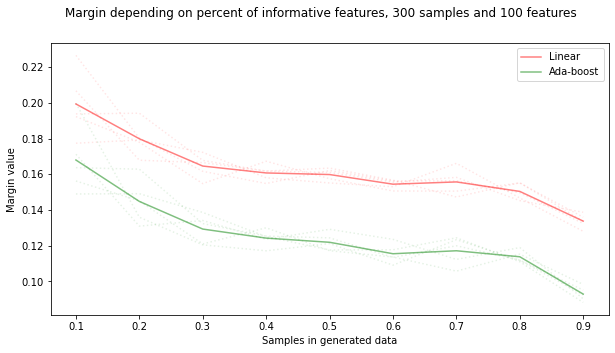

In [90]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Margin value')
plt.suptitle("Margin depending on percent of informative features, 300 samples and 100 features")

for pos in range(TESTS_COUNT):
    plt.plot(informative_percent_list, marginL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(informative_percent_list, marginJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(informative_percent_list, avg_marginL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(informative_percent_list, avg_marginJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

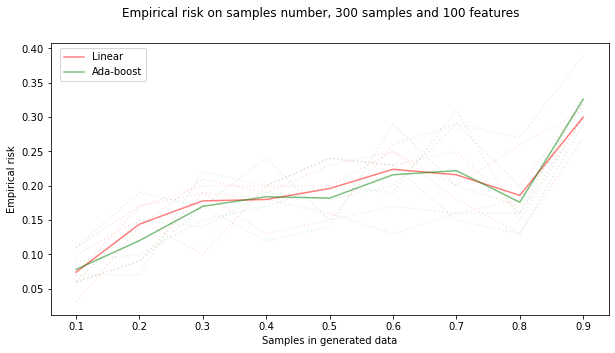

In [96]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Empirical risk')
plt.suptitle("Empirical risk on samples number, 300 samples and 100 features")

for pos in range(TESTS_COUNT):
    plt.plot(informative_percent_list, riskL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(informative_percent_list, riskJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(informative_percent_list, avg_riskL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(informative_percent_list, avg_riskJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(0.18, 1))

#### 3.1. Checking for statistically significant differences between experimental errors of classifier versions

In [97]:
risk_flatL = riskL.flatten('F')
risk_flatJ = riskJ.flatten('F')
print("Sign test:", sign_test(risk_flatL - risk_flatJ))
print("Signed rank test:", sc.stats.wilcoxon(risk_flatL, risk_flatJ))
print("Mann-Whitney test:", sc.stats.mannwhitneyu(risk_flatL, risk_flatJ))

Sign test: (4.0, 0.2558750795433298)
Signed rank test: WilcoxonResult(statistic=323.5, pvalue=0.49435035198179755)
Mann-Whitney test: MannwhitneyuResult(statistic=1082.0, pvalue=0.5770252304313128)


### 4. Breast cancer data set

In [6]:
path = 'd:/Projects-my/ml/Ml-hse-final/data/breast-cancer/'

df = pd.read_csv(path+'breast-cancer-wisconsin.data', header=None)
df.fillna(0, inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [7]:
raw = df.to_numpy(copy=True)
x_data = raw[:, 1:10]
y_data = raw[:, 10].astype(int) - 3

print("Breast cancer: {} rows, {} features".format(x_data.shape[0], x_data.shape[1]))

Breast cancer: 699 rows, 9 features


#### 4.1. Check if dataset is separable

In [8]:
from sklearn import svm

clf = svm.SVC(C=10**5)
clf.fit(x_data, y_data)
y_pred = clf.predict(x_data)
accuracy_score(y_data, y_pred)

1.0

In [ ]:
TESTS_COUNT = 20

bc_riskL, bc_riskJ, bc_marginL, bc_marginJ = [], [], [], []
count = 0
#kf = KFold(n_splits=TESTS_COUNT, random_state=13, shuffle=True)
#for train_index, test_index in kf.split(x_data):
while count < TESTS_COUNT:
    #X_train, X_test = x_data[train_index], x_data[test_index]
    #y_train, y_test = y_data[train_index], y_data[test_index]
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=1/4)
    try:
        metricsL, metricsJ = get_metrics(X_train, X_test, y_train, y_test, n_estimators = 500)
        bc_riskL.append(metricsL['risk'])
        bc_riskJ.append(metricsJ['risk'])
        bc_marginL.append(metricsL['margin'])
        bc_marginJ.append(metricsJ['margin'])
        count += 1
    except Exception as err:
        print("Calculating error: {}".format(err))


Calculating error: AdaBoost classifier splits 0.9961832061068703 part of the data


#### 4.2. Geometric margin and emperical error estimations

In [ ]:
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(TESTS_COUNT))
print("Emperical error for linear algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(bc_riskL), np.std(bc_riskL)))
print("Emperical error for ada boost algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(bc_riskJ), np.std(bc_riskJ)))
print("Geometric margin for linear algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(bc_marginL), np.std(bc_marginL)))
print("Geometric margin for ada boost algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(bc_marginJ), np.std(bc_marginJ)))

#### 4.3. Checking for statistically significant differences between experimental errors of classifier versions

In [ ]:
print("Sign test:", sign_test(np.array(bc_riskL) - np.array(bc_riskJ)))
print("Signed rank test:", sc.stats.wilcoxon(bc_riskL, bc_riskJ))
print("Mann-Whitney test:", sc.stats.mannwhitneyu(bc_riskL, bc_riskJ))